In [1]:
import warnings
warnings.filterwarnings("ignore")
# pytorch 相關
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset,DataLoader
from torch.utils.data import random_split
from torchvision import models
# 其他
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
from copy import copy
import os
import sklearn.metrics as metrics
import seaborn as sns
import pandas as pd
!pip install wandb==0.16.5
import wandb
from wandb.keras import WandbCallback
!pip install git+https://github.com/Po-Hsun-Su/pytorch-ssim.git
import pytorch_ssim
!pip install git+https://github.com/qubvel/segmentation_models.pytorch
import segmentation_models_pytorch as smp
!pip install torchsummary
from torchsummary import summary

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 39.5 MB/s eta 0:00:0000:01
  Attempting uninstall: wandb
    Found existing installation: wandb 0.17.0
    Uninstalling wandb-0.17.0:
      Successfully uninstalled wandb-0.17.0


2024-06-20 04:05:28.324850: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-20 04:05:28.324955: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-20 04:05:28.456044: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


  Cloning https://github.com/Po-Hsun-Su/pytorch-ssim.git to /tmp/pip-req-build-m0virwox
  Running command git clone --filter=blob:none --quiet https://github.com/Po-Hsun-Su/pytorch-ssim.git /tmp/pip-req-build-m0virwox
  Resolved https://github.com/Po-Hsun-Su/pytorch-ssim.git to commit 3add4532d3f633316cba235da1c69e90f0dfb952
  Preparing metadata (setup.py) ... done
  Created wheel for pytorch_ssim: filename=pytorch_ssim-0.1-py3-none-any.whl size=2307 sha256=f0b8ac483fadde411100508b029c9e3f88de615dcb8cf7bb4bb8f76d5ba5ef52
  Stored in directory: /tmp/pip-ephem-wheel-cache-k9336waz/wheels/99/53/8e/13474869f278024f6ed5791806bdfe47cfde59f30fe0bc6dd5
Successfully built pytorch_ssim
  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-msn7ge1t
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-msn7ge1t
  Resolved https://github.com/qubvel/segmentation_models.pytorch to commit bd7f877f

# 一些function

In [30]:
def _get_paths_from_images(path):
  assert os.path.isdir(path), '{:s} is not a valid directory'.format(path)
  images = []
  for dirpath, _, fnames in sorted(os.walk(path)):
    for fname in sorted(fnames):
      img_path = os.path.join(dirpath, fname)
      images.append(img_path)
  assert images, '{:s} has no valid image file'.format(path) 
  return images

def tensor2uint(img):
  img = img.data.squeeze().float().clamp_(0, 1).cpu().numpy()
  if img.ndim == 3:
    img = np.transpose(img, (1, 2, 0))
  return np.uint8((img*255.0).round())

def uint2tensor4(img):
  if img.ndim == 2:
    img = np.expand_dims(img, axis=2)
  return torch.from_numpy(np.ascontiguousarray(img)).permute(2, 0, 1).float().div(255.).unsqueeze(0)

def uint2single(img):
  return np.float32(img/255.)

def imsave(img, img_path):
  img = np.squeeze(img)
  if img.ndim == 3:
    img = img[:, :, [2, 1, 0]]
  cv2.imwrite(img_path, img)

def imread_uint(path, n_channels=3):
    # input: path
    # output: HxWx3(RGB or GGG), or HxWx1 (G)
  if n_channels == 1:
    img = cv2.imread(path, 0)  # cv2.IMREAD_GRAYSCALE
    img = np.expand_dims(img, axis=2)  # HxWx1
  elif n_channels == 3:
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)  # BGR or G
    if img.ndim == 2:
      img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)  # GGG
    else:
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # RGB
  return img

def mkdir(path):
  if not os.path.exists(path):
    os.makedirs(path)

def get_image_paths(dataroot):
  paths = None  # return None if dataroot is None
  if isinstance(dataroot, str):
    paths = sorted(_get_paths_from_images(dataroot))
  elif isinstance(dataroot, list):
    paths = []
    for i in dataroot:
      paths += sorted(_get_paths_from_images(i))
  return paths

def single2tensor4(img):
  return torch.from_numpy(np.ascontiguousarray(img)).permute(2, 0, 1).float().unsqueeze(0)

def imsave(img, img_path):
  img = np.squeeze(img)
  if img.ndim == 3:
    img = img[:, :, [2, 1, 0]]
  cv2.imwrite(img_path, img)

def test_onesplit(model, L, refield=32, min_size=256, sf=1, modulo=1):
    '''
    model:
    L: input Low-quality image
    refield: effective receptive filed of the network, 32 is enough
    min_size: min_sizeXmin_size image, e.g., 256X256 image
    sf: scale factor for super-resolution, otherwise 1
    modulo: 1 if split
    '''
    h, w = L.size()[-2:]

    top = slice(0, (h//2//refield+1)*refield)
    bottom = slice(h - (h//2//refield+1)*refield, h)
    left = slice(0, (w//2//refield+1)*refield)
    right = slice(w - (w//2//refield+1)*refield, w)
    Ls = [L[..., top, left], L[..., top, right], L[..., bottom, left], L[..., bottom, right]]
    Es = [model(Ls[i]) for i in range(4)]
    b, c = Es[0].size()[:2]
    E = torch.zeros(b, c, sf * h, sf * w).type_as(L)
    E[..., :h//2*sf, :w//2*sf] = Es[0][..., :h//2*sf, :w//2*sf]
    E[..., :h//2*sf, w//2*sf:w*sf] = Es[1][..., :h//2*sf, (-w + w//2)*sf:]
    E[..., h//2*sf:h*sf, :w//2*sf] = Es[2][..., (-h + h//2)*sf:, :w//2*sf]
    E[..., h//2*sf:h*sf, w//2*sf:w*sf] = Es[3][..., (-h + h//2)*sf:, (-w + w//2)*sf:]
    return E

In [31]:
# check GPU
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('GPU state:', device)

GPU state: cuda:0


# 設置超參數

In [3]:
lr = 0.0001
batch_size = 4
epochs = 20

# 數據預處理

In [32]:
# Normalize 和 totensor
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     transforms.Normalize((0.5, ), (0.5, ))
])

val_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     transforms.Normalize((0.5, ), (0.5, ))
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     transforms.Normalize((0.5, ), (0.5, ))
])

# 切割train_validation & load_data

In [33]:
# 指定 training set 和 validation set 的路徑
input_path = '/kaggle/input/ncku-machine-learning-2024/dataset/train/input'
label_path = '/kaggle/input/ncku-machine-learning-2024/dataset/train/label'

train_image_list = sorted([os.path.join(input_path, f) for f in os.listdir(input_path) if f.endswith('.jpg')])
train_label_list = sorted([os.path.join(label_path, f) for f in os.listdir(label_path) if f.endswith('.jpg')])

# 切割
from sklearn.model_selection import train_test_split
train_input_path_list , val_input_path_list = train_test_split(train_image_list , test_size = 0.2 , random_state = 42)
train_label_path_list , val_label_path_list = train_test_split(train_label_list , test_size = 0.2 , random_state = 42)

# Dataset

In [48]:
class MLfinal(Dataset):
  def __init__(self, input_list , label_list , transform=None):
    self.input_list = input_list
    self.label_list = label_list
    self.transform = transform

  def __len__(self):
    return len(self.input_list)

  def __getitem__(self, idx):
    image_path = self.input_list[idx]
    label_path = self.label_list[idx]
    
    temp = image_path
#     image = self.transform(image)
    return temp , image_path , label_path
#     return temp , image , label

train_dataset = MLfinal(train_input_path_list , train_label_path_list , train_transform)
val_dataset = MLfinal(val_input_path_list , val_label_path_list , val_transform)

# Dataloader

In [49]:
train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True,num_workers=2)
val_loader = DataLoader(dataset=val_dataset,batch_size=batch_size,shuffle=False,num_workers=2)

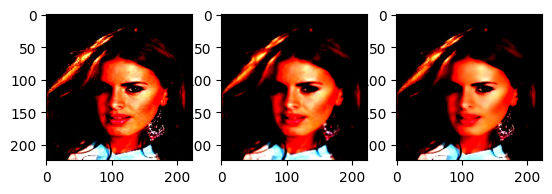

In [8]:
train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True,num_workers=2)
val_loader = DataLoader(dataset=val_dataset,batch_size=batch_size,shuffle=False,num_workers=2)

# 檢查 DataLoader 是否成功載入 image 和 ground truth
data_iter = iter(train_loader)
temps , images, labels = next(data_iter)

temp , image, label = temps[0] , images[0], labels[0]

fig , ax = plt.subplots(1 , 3)
ax[0].imshow(temp.permute(1, 2, 0))
ax[1].imshow(image.permute(1, 2, 0))
ax[2].imshow(label.permute(1, 2, 0))
# ax[0].imshow(image.permute(1, 2, 0) , cmap = 'gray')
# ax[1].imshow(label.permute(1, 2, 0) , cmap = 'gray')
plt.show()

# 定義模型

In [36]:
# -*- coding: utf-8 -*-
torch.cuda.empty_cache()
import math
import torch
import torch.nn as nn
import numpy as np
!pip install thop
from thop import profile
!pip install einops
from einops import rearrange 
from einops.layers.torch import Rearrange, Reduce
!pip install timm
from timm.models.layers import trunc_normal_, DropPath

In [37]:
torch.cuda.empty_cache()
class WMSA(nn.Module):
    """ Self-attention module in Swin Transformer
    """

    def __init__(self, input_dim, output_dim, head_dim, window_size, type):
        super(WMSA, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.head_dim = head_dim 
        self.scale = self.head_dim ** -0.5
        self.n_heads = input_dim//head_dim
        self.window_size = window_size
        self.type=type
        self.embedding_layer = nn.Linear(self.input_dim, 3*self.input_dim, bias=True)

        # TODO recover
        # self.relative_position_params = nn.Parameter(torch.zeros(self.n_heads, 2 * window_size - 1, 2 * window_size -1))
        self.relative_position_params = nn.Parameter(torch.zeros((2 * window_size - 1)*(2 * window_size -1), self.n_heads))

        self.linear = nn.Linear(self.input_dim, self.output_dim)

        trunc_normal_(self.relative_position_params, std=.02)
        self.relative_position_params = torch.nn.Parameter(self.relative_position_params.view(2*window_size-1, 2*window_size-1, self.n_heads).transpose(1,2).transpose(0,1))

    def generate_mask(self, h, w, p, shift):
        """ generating the mask of SW-MSA
        Args:
            shift: shift parameters in CyclicShift.
        Returns:
            attn_mask: should be (1 1 w p p),
        """
        # supporting sqaure.
        attn_mask = torch.zeros(h, w, p, p, p, p, dtype=torch.bool, device=self.relative_position_params.device)
        if self.type == 'W':
            return attn_mask

        s = p - shift
        attn_mask[-1, :, :s, :, s:, :] = True
        attn_mask[-1, :, s:, :, :s, :] = True
        attn_mask[:, -1, :, :s, :, s:] = True
        attn_mask[:, -1, :, s:, :, :s] = True
        attn_mask = rearrange(attn_mask, 'w1 w2 p1 p2 p3 p4 -> 1 1 (w1 w2) (p1 p2) (p3 p4)')
        return attn_mask

    def forward(self, x):
        """ Forward pass of Window Multi-head Self-attention module.
        Args:
            x: input tensor with shape of [b h w c];
            attn_mask: attention mask, fill -inf where the value is True; 
        Returns:
            output: tensor shape [b h w c]
        """
        if self.type!='W': x = torch.roll(x, shifts=(-(self.window_size//2), -(self.window_size//2)), dims=(1,2))
        x = rearrange(x, 'b (w1 p1) (w2 p2) c -> b w1 w2 p1 p2 c', p1=self.window_size, p2=self.window_size)
        h_windows = x.size(1)
        w_windows = x.size(2)
        # sqaure validation
        # assert h_windows == w_windows

        x = rearrange(x, 'b w1 w2 p1 p2 c -> b (w1 w2) (p1 p2) c', p1=self.window_size, p2=self.window_size)
        qkv = self.embedding_layer(x)
        q, k, v = rearrange(qkv, 'b nw np (threeh c) -> threeh b nw np c', c=self.head_dim).chunk(3, dim=0)
        sim = torch.einsum('hbwpc,hbwqc->hbwpq', q, k) * self.scale
        # Adding learnable relative embedding
        sim = sim + rearrange(self.relative_embedding(), 'h p q -> h 1 1 p q')
        # Using Attn Mask to distinguish different subwindows.
        if self.type != 'W':
            attn_mask = self.generate_mask(h_windows, w_windows, self.window_size, shift=self.window_size//2)
            sim = sim.masked_fill_(attn_mask, float("-inf"))

        probs = nn.functional.softmax(sim, dim=-1)
        output = torch.einsum('hbwij,hbwjc->hbwic', probs, v)
        output = rearrange(output, 'h b w p c -> b w p (h c)')
        output = self.linear(output)
        output = rearrange(output, 'b (w1 w2) (p1 p2) c -> b (w1 p1) (w2 p2) c', w1=h_windows, p1=self.window_size)

        if self.type!='W': output = torch.roll(output, shifts=(self.window_size//2, self.window_size//2), dims=(1,2))
        return output

    def relative_embedding(self):
        cord = torch.tensor(np.array([[i, j] for i in range(self.window_size) for j in range(self.window_size)]))
        relation = cord[:, None, :] - cord[None, :, :] + self.window_size -1
        # negative is allowed
        return self.relative_position_params[:, relation[:,:,0].long(), relation[:,:,1].long()]


class Block(nn.Module):
    def __init__(self, input_dim, output_dim, head_dim, window_size, drop_path, type='W', input_resolution=None):
        """ SwinTransformer Block
        """
        super(Block, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        assert type in ['W', 'SW']
        self.type = type
        if input_resolution <= window_size:
            self.type = 'W'

        print("Block Initial Type: {}, drop_path_rate:{:.6f}".format(self.type, drop_path))
        self.ln1 = nn.LayerNorm(input_dim)
        self.msa = WMSA(input_dim, input_dim, head_dim, window_size, self.type)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.ln2 = nn.LayerNorm(input_dim)
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, 4 * input_dim),
            nn.GELU(),
            nn.Linear(4 * input_dim, output_dim),
        )

    def forward(self, x):
        x = x + self.drop_path(self.msa(self.ln1(x)))
        x = x + self.drop_path(self.mlp(self.ln2(x)))
        return x


class ConvTransBlock(nn.Module):
    def __init__(self, conv_dim, trans_dim, head_dim, window_size, drop_path, type='W', input_resolution=None):
        """ SwinTransformer and Conv Block
        """
        super(ConvTransBlock, self).__init__()
        self.conv_dim = conv_dim
        self.trans_dim = trans_dim
        self.head_dim = head_dim
        self.window_size = window_size
        self.drop_path = drop_path
        self.type = type
        self.input_resolution = input_resolution

        assert self.type in ['W', 'SW']
        if self.input_resolution <= self.window_size:
            self.type = 'W'

        self.trans_block = Block(self.trans_dim, self.trans_dim, self.head_dim, self.window_size, self.drop_path, self.type, self.input_resolution)
        self.conv1_1 = nn.Conv2d(self.conv_dim+self.trans_dim, self.conv_dim+self.trans_dim, 1, 1, 0, bias=True)
        self.conv1_2 = nn.Conv2d(self.conv_dim+self.trans_dim, self.conv_dim+self.trans_dim, 1, 1, 0, bias=True)

        self.conv_block = nn.Sequential(
                nn.Conv2d(self.conv_dim, self.conv_dim, 3, 1, 1, bias=False),
                nn.ReLU(True),
                nn.Conv2d(self.conv_dim, self.conv_dim, 3, 1, 1, bias=False)
                )

    def forward(self, x):
        conv_x, trans_x = torch.split(self.conv1_1(x), (self.conv_dim, self.trans_dim), dim=1)
        conv_x = self.conv_block(conv_x) + conv_x
        trans_x = Rearrange('b c h w -> b h w c')(trans_x)
        trans_x = self.trans_block(trans_x)
        trans_x = Rearrange('b h w c -> b c h w')(trans_x)
        res = self.conv1_2(torch.cat((conv_x, trans_x), dim=1))
        x = x + res

        return x


class SCUNet(nn.Module):

    def __init__(self, in_nc=3, config=[2,2,2,2,2,2,2], dim=64, drop_path_rate=0.0, input_resolution=256):
        super(SCUNet, self).__init__()
        self.config = config
        self.dim = dim
        self.head_dim = 32
        self.window_size = 8

        # drop path rate for each layer
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(config))]

        self.m_head = [nn.Conv2d(in_nc, dim, 3, 1, 1, bias=False)]

        begin = 0
        self.m_down1 = [ConvTransBlock(dim//2, dim//2, self.head_dim, self.window_size, dpr[i+begin], 'W' if not i%2 else 'SW', input_resolution) 
                      for i in range(config[0])] + \
                      [nn.Conv2d(dim, 2*dim, 2, 2, 0, bias=False)]

        begin += config[0]
        self.m_down2 = [ConvTransBlock(dim, dim, self.head_dim, self.window_size, dpr[i+begin], 'W' if not i%2 else 'SW', input_resolution//2)
                      for i in range(config[1])] + \
                      [nn.Conv2d(2*dim, 4*dim, 2, 2, 0, bias=False)]

        begin += config[1]
        self.m_down3 = [ConvTransBlock(2*dim, 2*dim, self.head_dim, self.window_size, dpr[i+begin], 'W' if not i%2 else 'SW',input_resolution//4)
                      for i in range(config[2])] + \
                      [nn.Conv2d(4*dim, 8*dim, 2, 2, 0, bias=False)]

        begin += config[2]
        self.m_body = [ConvTransBlock(4*dim, 4*dim, self.head_dim, self.window_size, dpr[i+begin], 'W' if not i%2 else 'SW', input_resolution//8)
                    for i in range(config[3])]

        begin += config[3]
        self.m_up3 = [nn.ConvTranspose2d(8*dim, 4*dim, 2, 2, 0, bias=False),] + \
                      [ConvTransBlock(2*dim, 2*dim, self.head_dim, self.window_size, dpr[i+begin], 'W' if not i%2 else 'SW',input_resolution//4)
                      for i in range(config[4])]
                      
        begin += config[4]
        self.m_up2 = [nn.ConvTranspose2d(4*dim, 2*dim, 2, 2, 0, bias=False),] + \
                      [ConvTransBlock(dim, dim, self.head_dim, self.window_size, dpr[i+begin], 'W' if not i%2 else 'SW', input_resolution//2)
                      for i in range(config[5])]
                      
        begin += config[5]
        self.m_up1 = [nn.ConvTranspose2d(2*dim, dim, 2, 2, 0, bias=False),] + \
                    [ConvTransBlock(dim//2, dim//2, self.head_dim, self.window_size, dpr[i+begin], 'W' if not i%2 else 'SW', input_resolution) 
                      for i in range(config[6])]

        self.m_tail = [nn.Conv2d(dim, in_nc, 3, 1, 1, bias=False)]

        self.m_head = nn.Sequential(*self.m_head)
        self.m_down1 = nn.Sequential(*self.m_down1)
        self.m_down2 = nn.Sequential(*self.m_down2)
        self.m_down3 = nn.Sequential(*self.m_down3)
        self.m_body = nn.Sequential(*self.m_body)
        self.m_up3 = nn.Sequential(*self.m_up3)
        self.m_up2 = nn.Sequential(*self.m_up2)
        self.m_up1 = nn.Sequential(*self.m_up1)
        self.m_tail = nn.Sequential(*self.m_tail)  
        #self.apply(self._init_weights)

    def forward(self, x0):

        h, w = x0.size()[-2:]
        paddingBottom = int(np.ceil(h/64)*64-h)
        paddingRight = int(np.ceil(w/64)*64-w)
        x0 = nn.ReplicationPad2d((0, paddingRight, 0, paddingBottom))(x0)

        x1 = self.m_head(x0)
        x2 = self.m_down1(x1)
        x3 = self.m_down2(x2)
        x4 = self.m_down3(x3)
        x = self.m_body(x4)
        x = self.m_up3(x+x4)
        x = self.m_up2(x+x3)
        x = self.m_up1(x+x2)
        x = self.m_tail(x+x1)

        x = x[..., :h, :w]
        
        return x


    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

model = SCUNet(in_nc=3,config=[4,4,4,4,4,4,4],dim=64)
model.load_state_dict(torch.load("/kaggle/input/authors-model/scunet_color_15.pth"))
model.to(device)
summary(model, (3, 224, 224))
architecture = "SCUnet"

# class IOU(nn.Module):
#     def __init__(self, size_average=True):
#         super(IOU, self).__init__()
#         self.size_average = size_average

#     def forward(self, pred, target):
#         b = pred.shape[0]
#         IoU = 0.0
#         for i in range(b):
#             Iand1 = torch.sum(target[i, :, :, :] * pred[i, :, :, :])
#             Ior1 = torch.sum(target[i, :, :, :]) + torch.sum(pred[i, :, :, :]) - Iand1
#             IoU1 = Iand1 / Ior1
#             IoU += (1 - IoU1)
#         return IoU / b if self.size_average else IoU


# iou_loss_module = IOU(size_average=True)
# bce_loss_module = nn.BCEWithLogitsLoss()
# ssim_loss_module = pytorch_ssim.SSIM(window_size=11,size_average=True)
L1_loss_module = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Blo

# Wandb

In [38]:
# 紀錄數據
name = architecture
wandb.login(key = "bf1bc673d9b5cb8bf02f1937561fb29fcb06a207")
wandb.init(
    # set the wandb project where this run will be logged
    project = "NCKU ML final",
    name = name ,

    # track hyperparameters and run metadata
    config={
    "learning_rate": lr,
    "architecture": architecture,
    "epochs": epochs,
    "batch_size" : batch_size,
    }
)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: zxc93142819. Use `wandb login --relogin` to force relogin


In [ ]:
torch.cuda.empty_cache()
model.to(device)
# best model accurancy
train_loss = []
val_loss = []
best_loss = 100000
model_path = "./" + architecture + "_finetune_epochs" + str(epochs) + ".pth"

for epoch in range(epochs):
  train_epoch_loss = 0.0
  model.train()
  for temps , images, labels in train_loader :
    optimizer.zero_grad()
#     images = images.to(device)
#     labels = labels.to(device)
    batch_loss = 0.0
    for i in range(len(images)) :
      image = imread_uint(images[i], n_channels=3)
      label = imread_uint(labels[i], n_channels=3)
      
      image = uint2single(image)
      label = uint2single(label)
    
      np.random.seed(seed=0)  # for reproducibility
      image += np.random.normal(0, 15/255., image.shape)

      image = single2tensor4(image)
      label = single2tensor4(label)
      
      image = image.to(device)
      label = label.to(device)
      
      output = test_onesplit(model , image , refield = 64)
      batch_loss += L1_loss_module(output , label)
    
    train_epoch_loss += batch_loss.item()
    #　back propagation
    batch_loss.backward()
    # 更新
    optimizer.step()
    train_epoch_loss += batch_loss.item()
    
  # Compute Loss
  train_epoch_loss = train_epoch_loss / len(train_loader)
  train_loss.append(train_epoch_loss)

  print('[Epoch:%2d]' % (epoch + 1))
  print('Train Loss : %.3f ' % (train_epoch_loss))
    
#     if(epoch == 19) :
#     print(type(images[0]))
#     print(type(outputs[0]))
#     fig , ax = plt.subplots(1 , 2)
#     ax[0].imshow(images[0].cpu().permute(1, 2, 0))
#     ax[1].imshow(outputs[0].detach().cpu().permute(1, 2, 0))
#     plt.show()
#     #     print(images[1])
#     #     print(outputs[1])
#     fig , ax = plt.subplots(1 , 2)
#     ax[0].imshow(images[1].cpu().permute(1, 2, 0))
#     ax[1].imshow(outputs[1].detach().cpu().permute(1, 2, 0))
#     plt.show()
    
#     gray = transforms.Compose([
#         transforms.Grayscale(num_output_channels=1)
#     ])
#     outputs = gray(outputs)
#     labels = gray(labels)

    # Compute Loss & Update Weight
#     loss_iou = iou_loss_module(outputs, labels)
#     loss_bce = bce_loss_module(outputs, labels)
#     ssim_loss = 1 - ssim_loss_module(outputs,labels)
#     batch_loss = loss_iou + loss_bce + ssim_loss
#     batch_loss = ssim_loss
#     batch_loss = L1_loss_module(outputs , labels)
#     batch_loss += vgg_loss_module(outputs , labels)
#     batch_loss += vgg_loss_module(outputs.detach().cpu() , labels.cpu())
#     batch_loss += generator_loss(outputs.detach().cpu() , labels.cpu())
#     batch_loss += discriminator_loss(outputs.detach().cpu() , labels.cpu())
#     temp = 0.0
#     for i in range(len(outputs)) :
#         temp += vgg_loss_module(outputs[i] , labels[i])
#     temp /= len(outputs)
#     batch_loss += temp
    
  # Validation class correct & class total --------------------------------------------------------------
  model.eval()
  val_epoch_loss = 0.0

  # Validation every epoch
  with torch.no_grad():
    for temps , images, labels in val_loader :
#       images = images.to(device)
#       labels = labels.to(device)
      batch_loss = 0.0
      for i in range(len(images)) :
        image = imread_uint(images[i], n_channels=3)
        label = imread_uint(labels[i], n_channels=3)
      
        image = uint2single(image)
        label = uint2single(label)
    
        np.random.seed(seed=0)  # for reproducibility
        image += np.random.normal(0, 15/255., image.shape)

        image = single2tensor4(image)
        label = single2tensor4(label)
       
        image = image.to(device)
        label = label.to(device)
      
        output = test_onesplit(model , image , refield = 64)
        batch_loss += L1_loss_module(output , label)
    
      val_epoch_loss += batch_loss.item()
    
  
    val_epoch_loss = val_epoch_loss / len(val_loader)
    val_loss.append(val_epoch_loss)
  
    wandb.log( {"train_loss" : train_epoch_loss , "epoch" : epoch} )
    wandb.log( {"validation_loss" : val_epoch_loss , "epoch" : epoch} )
  
    print('Validation Loss : %.3f ' % (val_epoch_loss))
    print("----------------------------------------")

        
#       gray = transforms.Compose([
#         transforms.Grayscale(num_output_channels=1)
#       ])
#       outputs = gray(outputs)
#       labels = gray(labels)

      # Compute Loss & Update Weight
#       loss_iou = iou_loss_module(outputs, labels)
#       loss_bce = bce_loss_module(outputs, labels)
#       ssim_loss = 1 - ssim_loss_module(outputs,labels)
#       batch_loss = loss_iou + loss_bce + ssim_loss
#       batch_loss = L1_loss_module(outputs , labels)
#       batch_loss += vgg_loss_module(outputs , labels)
#       batch_loss += vgg_loss_module(outputs.detach().cpu() , labels.cpu())
#       batch_loss += generator_loss(outputs.detach().cpu() , labels.cpu())
#       batch_loss += discriminator_loss(outputs.detach().cpu() , labels.cpu())
#       temp = 0.0
#       for i in range(len(outputs)) :
#         temp += vgg_loss_module(outputs[i] , labels[i])
#       temp /= len(outputs)
#       batch_loss += temp

  # Save best model
  if val_epoch_loss < best_loss:
    best_loss = val_epoch_loss
    torch.save(model.state_dict() , model_path)

print('Finished Training')
wandb.finish()

In [ ]:
print(best_loss)

# test

In [14]:
test_image_root = "/kaggle/input/ncku-machine-learning-2024/dataset/test/input"
train_image_list = sorted([os.path.join(test_image_root, f) for f in os.listdir(test_image_root) if f.endswith('.jpg')])
class MLfinal_t(Dataset):
  def __init__(self, input_list , transform=None):
    self.input_list = input_list
    self.transform = transform

  def __len__(self):
    return len(self.input_list)

  def __getitem__(self, idx):
    image_path = self.input_list[idx]
    name = os.path.basename(image_path).split('.')[0]
    
    image = cv2.imread(image_path)
#     image = cv2.resize(cv2.imread(image_path) , (224, 224), interpolation=cv2.INTER_AREA)
    
    # 平滑化
#     mask = np.ones((3, 3), np.float32)/ (3 ** 2)
    # 將 mask apply 到原始圖像做 Smoothing
#     image = cv2.filter2D(image,-1,mask)
#     image = cv2.fastNlMeansDenoisingColored(image , None, 10, 10, 7, 21)

#   convert to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # convert 0~256 to 0~1
    image = np.float32(image/255.)
    
    # convert single (HxWxC) to 4-dimensional torch tensor
    image = torch.from_numpy(np.ascontiguousarray(image)).permute(2, 0, 1).float().unsqueeze(0)
    
#     image = self.transform(image)
    return image , name

test_dataset = MLfinal_t(train_image_list , test_transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# denormalized

In [35]:
# 定義反歸一化的transform
class Denormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

# 初始化反歸一化
denormalize = Denormalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

def denormalize_and_reshape(tensor):
    tensor = denormalize(tensor)
    tensor = tensor.permute(2, 1, 0)  # 將 (C, H, W) 轉換為 (H, W, C)
    tensor = torch.clamp(tensor, 0, 1)  # 限制像素值範圍在 [0, 1]
#     print(tensor.size())
    image = tensor.cpu().numpy()
    image = (image * 255).astype(np.uint8)
    print(type(image))
    print(image.shape)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     print(type(image))
    image = image.flatten()
#     print(type(image))
    return image
#     plt.imshow(image)

In [16]:
# model = smp.Unet('resnet50', in_channels=3 , classes=3, activation='sigmoid', encoder_weights='imagenet', decoder_use_batchnorm=True)
# model.load_state_dict(torch.load("/kaggle/working/Unet_epochs10.pth"))
# model.cuda()
# model.eval()

torch.cuda.empty_cache()
model.load_state_dict(torch.load("/kaggle/input/authors-model/scunet_color_15.pth") , strict = True)
model.eval()
model = model.to(device)
data = pd.DataFrame([])
save_path = "./result"
os.makedirs(save_path, exist_ok=True)

with torch.no_grad():
    for images , names in test_loader:
      images = images.cuda()
      for i in range(len(images)) :
        output = test_onesplit(model , images[i] , refield = 64)
        
#       tensor to int ----------------------------------------------------
        output = output.data.squeeze().float().clamp_(0, 1).cpu().numpy()
        if (output.ndim == 3) :
          output = np.transpose(output, (1, 2, 0))
#         print("index : %d" , int(names[i]) - 1)
#         print(np.uint8((output*255.0).round()))
#         img = np.uint8((output*255.0).round()).flatten()
        img = np.uint8((output*255.0).round())
#         -----------------------------------------------------------------
        
#       store image
        img = np.squeeze(img)
        if img.ndim == 3:
          img = img[:, :, [2, 1, 0]]
        name = str(int(names[i]) - 1) + ".jpg"
        success = cv2.imwrite(os.path.join(save_path, name) , img)
        if success:
          print(f"File saved successfully: {name}")
        else:
          print(f"Failed to save file: {name}")
        
        
        
#         arr2 = (output*255.0).astype(np.uint8).flatten()
#         print(arr1)
#         print(arr2)
#         print()
#         dict = {"index" : [int(names[i]) - 1] }
#         for j in range(178 * 218 * 3) :
#             dict[j] = arr1[j]
#         d = pd.DataFrame( dict )
#         data = pd.concat([data , d] , axis = 0)
            
# data.sort_values(by = ["index"] , na_position = "first")
# print(data)
        
        
        
        
        
#       results = model(images)
#       print(results[0])
#       print(results[1])
#       print(results[2])
#       results = images
#       results = F.interpolate(results , size=(178, 218), mode='bilinear', align_corners=False)
#       for i in range(len(results)) :
#           dict = {"index" : [int(names[i]) - 1] }
#           arr = denormalize_and_reshape(images[i])
#           array = denormalize_and_reshape(results[i])
#           print(arr)
#           print(array)
#           break
#           for j in range(178 * 218 * 3) :
#             dict[j] = array[j]
#           d = pd.DataFrame( dict )
#           print(d)
#           data = pd.concat([data , d] , axis = 0)

# data.sort_values(by = ["index"] , na_position = "first")
# print(data)

File saved successfully: 0.jpg
File saved successfully: 1.jpg
File saved successfully: 2.jpg
File saved successfully: 3.jpg
File saved successfully: 4.jpg
File saved successfully: 5.jpg
File saved successfully: 6.jpg
File saved successfully: 7.jpg
File saved successfully: 8.jpg
File saved successfully: 9.jpg
File saved successfully: 10.jpg
File saved successfully: 11.jpg
File saved successfully: 12.jpg
File saved successfully: 13.jpg
File saved successfully: 14.jpg
File saved successfully: 15.jpg
File saved successfully: 16.jpg
File saved successfully: 17.jpg
File saved successfully: 18.jpg
File saved successfully: 19.jpg
File saved successfully: 20.jpg
File saved successfully: 21.jpg
File saved successfully: 22.jpg
File saved successfully: 23.jpg
File saved successfully: 24.jpg
File saved successfully: 25.jpg
File saved successfully: 26.jpg
File saved successfully: 27.jpg
File saved successfully: 28.jpg
File saved successfully: 29.jpg
File saved successfully: 30.jpg
File saved success

In [17]:
data = pd.DataFrame([])
index = 0
input_path = '/kaggle/working/result'
input_list = sorted([os.path.join(input_path, f) for f in os.listdir(input_path) if f.endswith('.jpg')])
for path in input_list :
    i = Image.open(path).convert('RGB')
    array = np.array(i).flatten()
    dict = {"index" : [index] }
    index += 1
    for j in range(178 * 218 * 3) :
        dict[j] = array[j]
    d = pd.DataFrame( dict )
    data = pd.concat([data , d] , axis = 0)

data.sort_values(by = ["index"] , na_position = "first")
print(data)

    index    0    1    2    3    4    5    6    7    8  ...  116402  116403  \
0       0  254  230  194  254  230  194  254  230  194  ...      25     120   
0       1   62   51   45   62   51   45   62   51   45  ...      96     137   
0       2  230  226  243  230  226  243  231  227  244  ...      76     107   
0       3  138  131  113  138  131  113  138  131  113  ...     225     205   
0       4  206  225  240  206  225  240  206  225  240  ...      14      13   
..    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...     ...     ...   
0     495  254  254  252  254  254  252  254  254  252  ...       7      33   
0     496  203  202  208  203  202  208  203  202  208  ...      85     144   
0     497  235  135   47  234  134   46  234  134   46  ...     162     253   
0     498  248   50   67  247   49   66  247   49   66  ...      43      67   
0     499   57   55   60   56   52   53   58   53   47  ...      38      35   

    116404  116405  116406  116407  116408  116409 

In [17]:
data.to_csv("test.csv" , index = False)

In [26]:
def _get_paths_from_images(path):
  assert os.path.isdir(path), '{:s} is not a valid directory'.format(path)
  images = []
  for dirpath, _, fnames in sorted(os.walk(path)):
    for fname in sorted(fnames):
      img_path = os.path.join(dirpath, fname)
      images.append(img_path)
  assert images, '{:s} has no valid image file'.format(path) 
  return images

def tensor2uint(img):
  img = img.data.squeeze().float().clamp_(0, 1).cpu().numpy()
  if img.ndim == 3:
    img = np.transpose(img, (1, 2, 0))
  return np.uint8((img*255.0).round())

def uint2tensor4(img):
  if img.ndim == 2:
    img = np.expand_dims(img, axis=2)
  return torch.from_numpy(np.ascontiguousarray(img)).permute(2, 0, 1).float().div(255.).unsqueeze(0)

def uint2single(img):
  return np.float32(img/255.)

def imsave(img, img_path):
  img = np.squeeze(img)
  if img.ndim == 3:
    img = img[:, :, [2, 1, 0]]
  cv2.imwrite(img_path, img)

def imread_uint(path, n_channels=3):
    #  input: path
    # output: HxWx3(RGB or GGG), or HxWx1 (G)
  if n_channels == 1:
    img = cv2.imread(path, 0)  # cv2.IMREAD_GRAYSCALE
    img = np.expand_dims(img, axis=2)  # HxWx1
  elif n_channels == 3:
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)  # BGR or G
    if img.ndim == 2:
      img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)  # GGG
    else:
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # RGB
  return img

def mkdir(path):
  if not os.path.exists(path):
    os.makedirs(path)

def get_image_paths(dataroot):
  paths = None  # return None if dataroot is None
  if isinstance(dataroot, str):
    paths = sorted(_get_paths_from_images(dataroot))
  elif isinstance(dataroot, list):
    paths = []
    for i in dataroot:
      paths += sorted(_get_paths_from_images(i))
  return paths

def single2tensor4(img):
  return torch.from_numpy(np.ascontiguousarray(img)).permute(2, 0, 1).float().unsqueeze(0)

def imsave(img, img_path):
  img = np.squeeze(img)
  if img.ndim == 3:
    img = img[:, :, [2, 1, 0]]
  cv2.imwrite(img_path, img)

In [28]:
n_channels = 3        # fixed, 1 for grayscale image, 3 for color image
# ----------------------------------------
# L_path, E_path, H_path
# ----------------------------------------
L_path = "/kaggle/input/ncku-machine-learning-2024/dataset/test/input" # L_path, for Low-quality images
H_path = L_path                               # H_path, for High-quality images
E_path = "./r"   # E_path, for Estimated images
mkdir(E_path)

# ----------------------------------------
# load model
# ----------------------------------------
model.load_state_dict(torch.load("/kaggle/input/authors-model/scunet_color_15.pth"), strict=True)
model.eval()
model = model.to(device)

L_paths = get_image_paths(L_path)
H_paths = get_image_paths(H_path)

need_degradation = True

for idx, img in enumerate(L_paths):

    # ------------------------------------
    # (1) img_L
    # ------------------------------------
  img_name, ext = os.path.splitext(os.path.basename(img))
    # logger.info('{:->4d}--> {:>10s}'.format(idx+1, img_name+ext))
  img_L = imread_uint(img, n_channels=n_channels)
  img_L = uint2single(img_L)

  if need_degradation:  # degradation process
    np.random.seed(seed=0)  # for reproducibility
    img_L += np.random.normal(0, 15/255., img_L.shape)

  img_L = single2tensor4(img_L)
  img_L = img_L.to(device)
    # print(img_L.shape)

    # ------------------------------------
    # (2) img_E
    # ------------------------------------
    #img_E = utils_model.test_mode(model, img_L, mode=2, refield=64)
  img_E = test_onesplit(model , img_L , refield = 64)

    #img_E = model(img_L)

    # logger.info(img_E.shape)
  img_E = tensor2uint(img_E)
    # print(img_E)

  imsave(img_E, os.path.join(E_path, img_name+ext))

In [29]:
data = pd.DataFrame([])
index = 0
input_path = '/kaggle/working/r'
input_list = sorted([os.path.join(input_path, f) for f in os.listdir(input_path) if f.endswith('.jpg')])
for path in input_list :
    i = Image.open(path).convert('RGB')
    array = np.array(i).flatten()
    dict = {"index" : [index] }
    index += 1
    for j in range(178 * 218 * 3) :
        dict[j] = array[j]
    d = pd.DataFrame( dict )
    data = pd.concat([data , d] , axis = 0)

data.sort_values(by = ["index"] , na_position = "first")
print(data)

    index    0    1    2    3    4    5    6    7    8  ...  116402  116403  \
0       0  255  229  192  255  229  192  255  229  192  ...      20     120   
0       1   69   55   46   68   54   45   69   52   45  ...      92     138   
0       2  254  254  254  254  254  254  255  255  255  ...      92      95   
0       3   68   59   52  125  116  109   98   89   82  ...      88      58   
0       4  153  201  203  152  200  202  152  200  204  ...     201     144   
..    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...     ...     ...   
0     495  255  255  255  255  255  255  255  255  255  ...     114     159   
0     496  226   96   72  226   96   72  226   96   72  ...     147     223   
0     497  126   82   35  127   83   36  127   83   36  ...     133      33   
0     498   75   72   65   75   72   65   74   71   64  ...     231     242   
0     499    1    1    1    1    1    1    1    1    1  ...      56      53   

    116404  116405  116406  116407  116408  116409 